In [1]:
print("\n\nம ஹா ம்ரி த் யு ஞ் ஜ யா\n\n")



ம ஹா ம்ரி த் யு ஞ் ஜ யா




In [2]:
import pandas as pd
import numpy as np
import time, os, glob

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

import keras
from keras.models import Model
from keras.layers import Input, LSTM, Dense, LSTMCell, RNN, Bidirectional, concatenate
from keras.optimizers import Adam

from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score


Using TensorFlow backend.


In [3]:
path='/Users/manjunath.adinarayan/TIME-SERIES/YAHOO_Data/A1Benchmark/'
path='/Users/manjunath.adinarayan/TIME-SERIES/YAHOO_Data/A2Benchmark/'

file='real_38.csv'
file='synthetic_18.csv'
df = pd.read_csv(os.path.join(path,file), header=0)

In [4]:
df.head()

,timestamp,value,is_anomaly
0,1416726000,-109.796772,0
1,1416729600,105.443021,0
2,1416733200,-10.573313,0
3,1416736800,497.612830,0
4,1416740400,336.279685,0


In [5]:
series = df['value']

In [6]:
seq = series.copy()

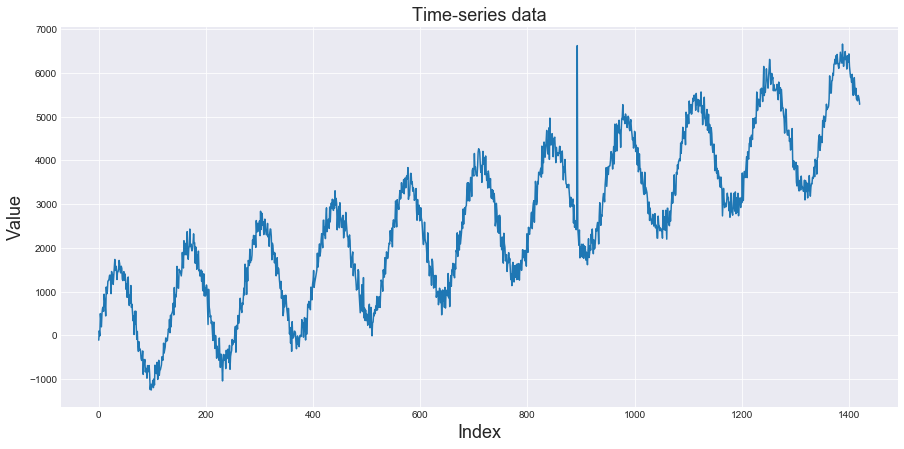

In [7]:
plt.figure(figsize=(15,7))
plt.title("Time-series data", fontsize = 18)
plt.xlabel("Index", fontsize = 18)
plt.ylabel("Value", fontsize = 18)
plt.plot(seq)
plt.show()

# START

functions

initializations

code flow

evaluation

plots

In [8]:
def get_score(y_true, y_pred):
    s = np.sqrt((y_true - y_pred)**2)
    
    return s

In [9]:
def moving_average(ts, n) :
    ret = np.cumsum(ts, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    ret[n:] = ret[n:] / n

    for i in range(1, n):
        ret[i] /= i + 1

    return ret

In [28]:
def data_preparing(data, filename, forecasting_length=1):
    test_signal = data.value.values
#    ma = moving_average(test_signal, n=24)
#    kpi = test_signal - ma # detrend
    kpi = test_signal
    kpi = np.array(kpi).reshape((len(kpi), 1))
    
    # train the standardization
    scaler = MinMaxScaler()
    scaler = scaler.fit(kpi)
    # standardization the dataset and print the first 5 rows
    normalized = scaler.transform(kpi)
    kept_value = normalized.flatten().tolist()

    kept_values = []
    for i in range(len(kept_value)):
        #kept_values.append([kept_value[i]]+time_encoder[i].tolist())
        kept_values.append(kept_value[i])
    X,Y, Y_anom_true_label = [],[], []
    for i in range(len(kept_values) - input_seq_len):
        t=i+input_seq_len
        X.append(kept_values[i:t])
        Y.append(kept_value[t:t + forecasting_length])
        #Y_anom_true_label.append(data.is_anomaly.values[t])
        if "Benchmark" in filename: 
            Y_anom_true_label.append(data.anomaly.values[t])
        else:
            Y_anom_true_label.append(data.is_anomaly.values[t])
    #X = np.asarray(X)
    X = np.expand_dims(X, axis=2)
    Y = np.expand_dims(Y, axis=2)
    
    Xmax = float(scaler.data_max_)
    Xmin = float(scaler.data_min_)

#    Xfull = X.transpose((1, 0, 2))
#    Yfull = Y.transpose((1, 0, 2))
 
    return X, Y, Xmax, Xmin, Y_anom_true_label

In [11]:
def generate_sequences(x):
    
    total_start_points = len(x) - input_seq_len - output_seq_len
    start_x_idx = np.random.choice(range(total_start_points), total_start_points, replace = False)
    
    input_batch_idxs = [(range(i, i+input_seq_len)) for i in start_x_idx]
    input_seq = np.take(x, input_batch_idxs, axis = 0)
    
    output_batch_idxs = [(range(i+input_seq_len, i+input_seq_len+output_seq_len)) for i in start_x_idx]
    output_seq = np.take(x, output_batch_idxs, axis = 0)
    
    input_seq =(input_seq.reshape(input_seq.shape[0],input_seq.shape[1],n_in_features))
    output_seq=(output_seq.reshape(output_seq.shape[0],output_seq.shape[1],n_out_features))
    
    return input_seq, output_seq

In [12]:
def create_model(layers, bidirectional=False):
    
    n_layers = len(layers)
    
    ## Encoder
    encoder_inputs = Input(shape=(None, n_in_features))
    lstm_cells = [LSTMCell(hidden_dim) for hidden_dim in layers]
    if bidirectional:
        encoder = Bidirectional(RNN(lstm_cells, return_state=True))
        encoder_outputs_and_states = encoder(encoder_inputs)
        bi_encoder_states = encoder_outputs_and_states[1:]
        encoder_states = []
        for i in range(int(len(bi_encoder_states)/2)):
            temp = concatenate([bi_encoder_states[i],bi_encoder_states[2*n_layers + i]], axis=-1)
            encoder_states.append(temp)
    else:  
        encoder = RNN(lstm_cells, return_state=True)
        encoder_outputs_and_states = encoder(encoder_inputs)
        encoder_states = encoder_outputs_and_states[1:]
    
    ## Decoder
    decoder_inputs = Input(shape=(None, n_out_features))
    if bidirectional:
        decoder_cells = [LSTMCell(hidden_dim*2) for hidden_dim in layers]
    else:
        decoder_cells = [LSTMCell(hidden_dim) for hidden_dim in layers]
        
    decoder_lstm = RNN(decoder_cells, return_sequences=True, return_state=True)

    decoder_outputs_and_states = decoder_lstm(decoder_inputs,
                                          initial_state=encoder_states)
    decoder_outputs = decoder_outputs_and_states[0]

    decoder_dense = Dense(n_out_features) 
    decoder_outputs = decoder_dense(decoder_outputs)
    
    model = Model([encoder_inputs,decoder_inputs], decoder_outputs)
    return model

In [13]:
def run_model(model,batches,epochs,batch_size):
    early_stop_callback = EarlyStopping(monitor='val_loss', patience=36)
    checkpoint_callback = ModelCheckpoint(model_name, monitor='val_loss', verbose=0, save_best_only=True, mode='min')

    for _ in range(batches):

        input_seq, output_seq = generate_sequences(x_train)

        encoder_input_data = input_seq
        decoder_target_data = output_seq
        decoder_input_data = np.zeros(decoder_target_data.shape)

        history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                             batch_size=batch_size,
                             epochs=epochs,
                             validation_split=0.2, 
                             verbose=0,
                             callbacks=[early_stop_callback, checkpoint_callback],
                             shuffle=False)
                           
        total_loss.append(history.history['loss'])
        total_val_loss.append(history.history['val_loss'])

In [14]:
input_seq_len = 48
output_seq_len = 1
n_in_features = 1
n_out_features = 1
batch_size = 64

model_name = 'best_saved_model.h5'

In [ ]:
maha

# A1

In [15]:
path='/Users/manjunath.adinarayan/TIME-SERIES/YAHOO_Data/A1Benchmark/'
#path='/Users/manjunath.adinarayan/TIME-SERIES/YAHOO_Data/A2Benchmark/'

extension='csv'
os.chdir( path )
files = glob.glob('*.{}'.format(extension))
len(files)

67

In [ ]:
f1score_dict2 = {}
prec_list2, rec_list2, f1score_list2 = [], [], []

start_time = time.time()

for file in files:

    df = pd.read_csv(os.path.join(path,file), header=0)
    seq = df['value'].values
    scaler = MinMaxScaler(feature_range=(-1,1))
    X =scaler.fit_transform(seq.reshape(-1,1))

    train_split = 0.8
    test_split = 0.2

    x_train = X[:int(len(X)*train_split)]
    test = X[-int(len(X)*test_split):]
    #tst_input_seq, tst_output_seq = generate_sequences(test)
    Xfull, Yfull, Xmax, Xmin, Y_anom_true_label = data_preparing(df, file)
    #Xfull.shape, Yfull.shape, len(Y_anom_true_label)

    # UNIDIRECTIONAL
    model_1 = create_model(layers=[16,32,16],bidirectional=False)

    total_loss = []
    total_val_loss = []
    model_1.compile(Adam(), loss = 'mean_squared_error')

    run_model(model_1,batches=1, epochs=180, batch_size=batch_size)

    model = load_model(model_name)

    #tst_input_seq, tst_output_seq = generate_sequences(test)
    #ts_enc_ip_data = tst_input_seq
    #ts_dec_ip_data = np.zeros(tst_output_seq.shape)

    #ts_pred_out = model.predict([ts_enc_ip_data, ts_dec_ip_data])
    #ts_pred_out.shape

    full_enc_ip_data = Xfull
    full_dec_ip_data = np.zeros(Yfull.shape)

    full_pred_out = model.predict([full_enc_ip_data, full_dec_ip_data])
    #full_pred_out.shape

    ####### ANOM-DETECT:
    true_Yfull = Yfull.reshape(Yfull.shape[0], 1)
    full_pred_out = full_pred_out.reshape(full_pred_out.shape[0], 1)

    score = get_score(true_Yfull, full_pred_out)
    pred_labels = []
    for j in range(0, len(score)):
    #    if score[j] <( np.mean(score) - 3.5*np.std(score) ) or score[j] >( np.mean(score) + 3.5*np.std(score) ):
        if score[j] <( np.mean(score) - 3*np.std(score) ) or score[j] >( np.mean(score) + 3*np.std(score) ):
    #    if score[j] > np.percentile(score, 99):
            pred_labels.append(1)
        else:
            pred_labels.append(0)

    prec_list2.append(precision_score(Y_anom_true_label, pred_labels) )
    recall_ = recall_score(Y_anom_true_label, pred_labels)
    rec_list2.append( recall_ )
    fscore_ = f1_score(Y_anom_true_label, pred_labels)
    f1score_list2.append( fscore_ )

    f1score_dict2[file] = f1_score(Y_anom_true_label, pred_labels)
    #print( file, np.mean(prec_list2), np.mean(rec_list2), np.mean(f1score_list2) )
    print( file, "Recall =", recall_, "Fscore =", fscore_ )

    plt.rcParams['figure.figsize'] = [18, 12]

    plt.figure()
    plt.plot(true_Yfull, alpha = 0.4, color='blue')
    plt.plot(full_pred_out, alpha = 0.9, color='yellow')
    index_changes = np.where(np.asarray(Y_anom_true_label) == 1)[0]
    plt.scatter(index_changes, true_Yfull[index_changes], c = 'red', label = "change point")
    plt.show()


    plt.figure()
    plt.plot(true_Yfull, alpha = 0.8, color='violet')
    plt.plot(full_pred_out, alpha = 1, color='orange')
    tr_index_changes = np.where(np.asarray(pred_labels) == 1)[0]
    plt.scatter(tr_index_changes, true_Yfull[tr_index_changes], c='black', label="change point")
    plt.show()
    
    del model
    keras.backend.clear_session()

In [17]:
print( np.mean(prec_list2), np.mean(rec_list2), np.mean(f1score_list2) )


0.5923527410221276 0.5445756063340303 0.5060529617642073


In [18]:
f1score_dict2

{'real_59.csv': 0.0,
 'real_65.csv': 0.4117647058823529,
 'real_64.csv': 0.0,
 'real_58.csv': 0.951219512195122,
 'real_66.csv': 0.8837209302325582,
 'real_67.csv': 0.5238095238095238,
 'real_63.csv': 0.6,
 'real_62.csv': 0.7142857142857143,
 'real_60.csv': 0.7692307692307693,
 'real_48.csv': 0.0,
 'real_49.csv': 0.28571428571428575,
 'real_61.csv': 0.05,
 'real_12.csv': 1.0,
 'real_5.csv': 1.0,
 'real_4.csv': 0.7142857142857143,
 'real_13.csv': 0.8,
 'real_39.csv': 0.7499999999999999,
 'real_11.csv': 0.7333333333333334,
 'real_6.csv': 0.823529411764706,
 'real_7.csv': 0.16216216216216217,
 'real_10.csv': 0.962962962962963,
 'real_38.csv': 0.26666666666666666,
 'real_14.csv': 0.23529411764705882,
 'real_28.csv': 0.0,
 'real_3.csv': 0.9655172413793104,
 'real_2.csv': 0.6666666666666666,
 'real_29.csv': 0.4761904761904762,
 'real_15.csv': 0.888888888888889,
 'real_17.csv': 0.2932330827067669,
 'real_1.csv': 0.25,
 'real_16.csv': 0.8,
 'real_33.csv': 0.8,
 'real_27.csv': 0.666666666666666

In [19]:
end_time = time.time()
print("Time taken = ", (end_time-start_time)/60, "minutes")

Time taken =  476.70415696700417 minutes


In [20]:
#maha

# A2

In [21]:
path='/Users/manjunath.adinarayan/TIME-SERIES/YAHOO_Data/A2Benchmark/'

extension='csv'
os.chdir( path )
files = glob.glob('*.{}'.format(extension))
len(files)

100

In [ ]:
f1score_dict2 = {}
prec_list2, rec_list2, f1score_list2 = [], [], []

start_time = time.time()

for file in files:

    df = pd.read_csv(os.path.join(path,file), header=0)
    seq = df['value'].values
    scaler = MinMaxScaler(feature_range=(-1,1))
    X =scaler.fit_transform(seq.reshape(-1,1))

    train_split = 0.8
    test_split = 0.2

    x_train = X[:int(len(X)*train_split)]
    test = X[-int(len(X)*test_split):]
    #tst_input_seq, tst_output_seq = generate_sequences(test)
    Xfull, Yfull, Xmax, Xmin, Y_anom_true_label = data_preparing(df, file)
    #Xfull.shape, Yfull.shape, len(Y_anom_true_label)

    # UNIDIRECTIONAL
    model_1 = create_model(layers=[16,32,16],bidirectional=False)

    total_loss = []
    total_val_loss = []
    model_1.compile(Adam(), loss = 'mean_squared_error')

    run_model(model_1,batches=1, epochs=180, batch_size=batch_size)

    model = load_model(model_name)

    #tst_input_seq, tst_output_seq = generate_sequences(test)
    #ts_enc_ip_data = tst_input_seq
    #ts_dec_ip_data = np.zeros(tst_output_seq.shape)

    #ts_pred_out = model.predict([ts_enc_ip_data, ts_dec_ip_data])
    #ts_pred_out.shape

    full_enc_ip_data = Xfull
    full_dec_ip_data = np.zeros(Yfull.shape)

    full_pred_out = model.predict([full_enc_ip_data, full_dec_ip_data])
    #full_pred_out.shape

    ####### ANOM-DETECT:
    true_Yfull = Yfull.reshape(Yfull.shape[0], 1)
    full_pred_out = full_pred_out.reshape(full_pred_out.shape[0], 1)

    score = get_score(true_Yfull, full_pred_out)
    pred_labels = []
    for j in range(0, len(score)):
    #    if score[j] <( np.mean(score) - 3.5*np.std(score) ) or score[j] >( np.mean(score) + 3.5*np.std(score) ):
        if score[j] <( np.mean(score) - 3*np.std(score) ) or score[j] >( np.mean(score) + 3*np.std(score) ):
    #    if score[j] > np.percentile(score, 99):
            pred_labels.append(1)
        else:
            pred_labels.append(0)

    prec_list2.append(precision_score(Y_anom_true_label, pred_labels) )
    recall_ = recall_score(Y_anom_true_label, pred_labels)
    rec_list2.append( recall_ )
    fscore_ = f1_score(Y_anom_true_label, pred_labels)
    f1score_list2.append( fscore_ )

    f1score_dict2[file] = f1_score(Y_anom_true_label, pred_labels)
    #print( file, np.mean(prec_list2), np.mean(rec_list2), np.mean(f1score_list2) )
    print( file, "Recall =", recall_, "Fscore =", fscore_ )

    plt.rcParams['figure.figsize'] = [18, 12]

    plt.figure()
    plt.plot(true_Yfull, alpha = 0.4, color='blue')
    plt.plot(full_pred_out, alpha = 0.9, color='yellow')
    index_changes = np.where(np.asarray(Y_anom_true_label) == 1)[0]
    plt.scatter(index_changes, true_Yfull[index_changes], c = 'red', label = "change point")
    plt.show()


    plt.figure()
    plt.plot(true_Yfull, alpha = 0.8, color='violet')
    plt.plot(full_pred_out, alpha = 1, color='orange')
    tr_index_changes = np.where(np.asarray(pred_labels) == 1)[0]
    plt.scatter(tr_index_changes, true_Yfull[tr_index_changes], c='black', label="change point")
    plt.show()
    
    del model
    keras.backend.clear_session()

In [23]:
print( np.mean(prec_list2), np.mean(rec_list2), np.mean(f1score_list2) )


0.8269025974025975 0.94 0.8457527485302421


In [24]:
f1score_dict2

{'synthetic_85.csv': 1.0,
 'synthetic_91.csv': 1.0,
 'synthetic_46.csv': 1.0,
 'synthetic_52.csv': 0.7272727272727273,
 'synthetic_53.csv': 1.0,
 'synthetic_47.csv': 1.0,
 'synthetic_90.csv': 1.0,
 'synthetic_84.csv': 1.0,
 'synthetic_92.csv': 1.0,
 'synthetic_86.csv': 1.0,
 'synthetic_51.csv': 1.0,
 'synthetic_45.csv': 0.5,
 'synthetic_79.csv': 1.0,
 'synthetic_78.csv': 0.2222222222222222,
 'synthetic_100.csv': 1.0,
 'synthetic_44.csv': 1.0,
 'synthetic_50.csv': 0.9,
 'synthetic_87.csv': 0.6666666666666666,
 'synthetic_93.csv': 1.0,
 'synthetic_97.csv': 1.0,
 'synthetic_83.csv': 0.9411764705882353,
 'synthetic_68.csv': 1.0,
 'synthetic_54.csv': 0.0,
 'synthetic_40.csv': 0.6666666666666666,
 'synthetic_41.csv': 1.0,
 'synthetic_55.csv': 1.0,
 'synthetic_69.csv': 1.0,
 'synthetic_82.csv': 0.888888888888889,
 'synthetic_96.csv': 0.6666666666666666,
 'synthetic_80.csv': 0.9,
 'synthetic_94.csv': 0.8,
 'synthetic_43.csv': 0.8,
 'synthetic_57.csv': 0.2222222222222222,
 'synthetic_56.csv': 1

In [25]:
end_time = time.time()
print("Time taken = ", (end_time-start_time)/60, "minutes")

Time taken =  213.7480659166972 minutes


# A3

In [29]:
path='/Users/manjunath.adinarayan/TIME-SERIES/YAHOO_Data/A3Benchmark/'

extension='csv'
os.chdir( path )
files = glob.glob('*.{}'.format(extension))
len(files)

100

In [ ]:
f1score_dict2 = {}
prec_list2, rec_list2, f1score_list2 = [], [], []

start_time = time.time()

for file in files:

    df = pd.read_csv(os.path.join(path,file), header=0)
    seq = df['value'].values
    scaler = MinMaxScaler(feature_range=(-1,1))
    X =scaler.fit_transform(seq.reshape(-1,1))

    train_split = 0.8
    test_split = 0.2

    x_train = X[:int(len(X)*train_split)]
    test = X[-int(len(X)*test_split):]
    #tst_input_seq, tst_output_seq = generate_sequences(test)
    Xfull, Yfull, Xmax, Xmin, Y_anom_true_label = data_preparing(df, file)
    #Xfull.shape, Yfull.shape, len(Y_anom_true_label)

    # UNIDIRECTIONAL
    model_1 = create_model(layers=[16,32,16],bidirectional=False)

    total_loss = []
    total_val_loss = []
    model_1.compile(Adam(), loss = 'mean_squared_error')

    run_model(model_1,batches=1, epochs=180, batch_size=batch_size)

    model = load_model(model_name)

    #tst_input_seq, tst_output_seq = generate_sequences(test)
    #ts_enc_ip_data = tst_input_seq
    #ts_dec_ip_data = np.zeros(tst_output_seq.shape)

    #ts_pred_out = model.predict([ts_enc_ip_data, ts_dec_ip_data])
    #ts_pred_out.shape

    full_enc_ip_data = Xfull
    full_dec_ip_data = np.zeros(Yfull.shape)

    full_pred_out = model.predict([full_enc_ip_data, full_dec_ip_data])
    #full_pred_out.shape

    ####### ANOM-DETECT:
    true_Yfull = Yfull.reshape(Yfull.shape[0], 1)
    full_pred_out = full_pred_out.reshape(full_pred_out.shape[0], 1)

    score = get_score(true_Yfull, full_pred_out)
    pred_labels = []
    for j in range(0, len(score)):
    #    if score[j] <( np.mean(score) - 3.5*np.std(score) ) or score[j] >( np.mean(score) + 3.5*np.std(score) ):
        if score[j] <( np.mean(score) - 3*np.std(score) ) or score[j] >( np.mean(score) + 3*np.std(score) ):
    #    if score[j] > np.percentile(score, 99):
            pred_labels.append(1)
        else:
            pred_labels.append(0)

    prec_list2.append(precision_score(Y_anom_true_label, pred_labels) )
    recall_ = recall_score(Y_anom_true_label, pred_labels)
    rec_list2.append( recall_ )
    fscore_ = f1_score(Y_anom_true_label, pred_labels)
    f1score_list2.append( fscore_ )

    f1score_dict2[file] = f1_score(Y_anom_true_label, pred_labels)
    #print( file, np.mean(prec_list2), np.mean(rec_list2), np.mean(f1score_list2) )
    print( file, "Recall =", recall_, "Fscore =", fscore_ )

    plt.rcParams['figure.figsize'] = [18, 12]

    plt.figure()
    plt.plot(true_Yfull, alpha = 0.4, color='blue')
    plt.plot(full_pred_out, alpha = 0.9, color='yellow')
    index_changes = np.where(np.asarray(Y_anom_true_label) == 1)[0]
    plt.scatter(index_changes, true_Yfull[index_changes], c = 'red', label = "change point")
    plt.show()


    plt.figure()
    plt.plot(true_Yfull, alpha = 0.8, color='violet')
    plt.plot(full_pred_out, alpha = 1, color='orange')
    tr_index_changes = np.where(np.asarray(pred_labels) == 1)[0]
    plt.scatter(tr_index_changes, true_Yfull[tr_index_changes], c='black', label="change point")
    plt.show()
    
    del model
    keras.backend.clear_session()

In [30]:
print( np.mean(prec_list2), np.mean(rec_list2), np.mean(f1score_list2) )


In [31]:
f1score_dict2

In [ ]:
end_time = time.time()
print("Time taken = ", (end_time-start_time)/60, "minutes")

# A4

In [ ]:
path='/Users/manjunath.adinarayan/TIME-SERIES/YAHOO_Data/A4Benchmark/'

extension='csv'
os.chdir( path )
files = glob.glob('*.{}'.format(extension))
len(files)

In [ ]:
f1score_dict2 = {}
prec_list2, rec_list2, f1score_list2 = [], [], []

start_time = time.time()

for file in files:

    df = pd.read_csv(os.path.join(path,file), header=0)
    seq = df['value'].values
    scaler = MinMaxScaler(feature_range=(-1,1))
    X =scaler.fit_transform(seq.reshape(-1,1))

    train_split = 0.8
    test_split = 0.2

    x_train = X[:int(len(X)*train_split)]
    test = X[-int(len(X)*test_split):]
    #tst_input_seq, tst_output_seq = generate_sequences(test)
    Xfull, Yfull, Xmax, Xmin, Y_anom_true_label = data_preparing(df, file)
    #Xfull.shape, Yfull.shape, len(Y_anom_true_label)

    # UNIDIRECTIONAL
    model_1 = create_model(layers=[16,32,16],bidirectional=False)

    total_loss = []
    total_val_loss = []
    model_1.compile(Adam(), loss = 'mean_squared_error')

    run_model(model_1,batches=1, epochs=180, batch_size=batch_size)

    model = load_model(model_name)

    #tst_input_seq, tst_output_seq = generate_sequences(test)
    #ts_enc_ip_data = tst_input_seq
    #ts_dec_ip_data = np.zeros(tst_output_seq.shape)

    #ts_pred_out = model.predict([ts_enc_ip_data, ts_dec_ip_data])
    #ts_pred_out.shape

    full_enc_ip_data = Xfull
    full_dec_ip_data = np.zeros(Yfull.shape)

    full_pred_out = model.predict([full_enc_ip_data, full_dec_ip_data])
    #full_pred_out.shape

    ####### ANOM-DETECT:
    true_Yfull = Yfull.reshape(Yfull.shape[0], 1)
    full_pred_out = full_pred_out.reshape(full_pred_out.shape[0], 1)

    score = get_score(true_Yfull, full_pred_out)
    pred_labels = []
    for j in range(0, len(score)):
    #    if score[j] <( np.mean(score) - 3.5*np.std(score) ) or score[j] >( np.mean(score) + 3.5*np.std(score) ):
        if score[j] <( np.mean(score) - 3*np.std(score) ) or score[j] >( np.mean(score) + 3*np.std(score) ):
    #    if score[j] > np.percentile(score, 99):
            pred_labels.append(1)
        else:
            pred_labels.append(0)

    prec_list2.append(precision_score(Y_anom_true_label, pred_labels) )
    recall_ = recall_score(Y_anom_true_label, pred_labels)
    rec_list2.append( recall_ )
    fscore_ = f1_score(Y_anom_true_label, pred_labels)
    f1score_list2.append( fscore_ )

    f1score_dict2[file] = f1_score(Y_anom_true_label, pred_labels)
    #print( file, np.mean(prec_list2), np.mean(rec_list2), np.mean(f1score_list2) )
    print( file, "Recall =", recall_, "Fscore =", fscore_ )

    plt.rcParams['figure.figsize'] = [18, 12]

    plt.figure()
    plt.plot(true_Yfull, alpha = 0.4, color='blue')
    plt.plot(full_pred_out, alpha = 0.9, color='yellow')
    index_changes = np.where(np.asarray(Y_anom_true_label) == 1)[0]
    plt.scatter(index_changes, true_Yfull[index_changes], c = 'red', label = "change point")
    plt.show()


    plt.figure()
    plt.plot(true_Yfull, alpha = 0.8, color='violet')
    plt.plot(full_pred_out, alpha = 1, color='orange')
    tr_index_changes = np.where(np.asarray(pred_labels) == 1)[0]
    plt.scatter(tr_index_changes, true_Yfull[tr_index_changes], c='black', label="change point")
    plt.show()
    
    del model
    keras.backend.clear_session()

In [26]:
print( np.mean(prec_list2), np.mean(rec_list2), np.mean(f1score_list2) )


0.46886797003174946 0.5856368215118216 0.4371326418072167


In [29]:
len(f1score_dict2)

100

In [28]:
f1score_dict2

{'A4Benchmark-TS99.csv': 0.3703703703703704,
 'A4Benchmark-TS72.csv': 0.33333333333333337,
 'A4Benchmark-TS66.csv': 0.0,
 'A4Benchmark-TS67.csv': 0.7777777777777778,
 'A4Benchmark-TS73.csv': 0.28571428571428575,
 'A4Benchmark-TS98.csv': 0.8000000000000002,
 'A4Benchmark-TS65.csv': 0.9655172413793104,
 'A4Benchmark-TS71.csv': 0.4285714285714285,
 'A4Benchmark-TS59.csv': 0.0,
 'A4Benchmark-TS58.csv': 0.09302325581395347,
 'A4Benchmark-TS70.csv': 0.5,
 'A4Benchmark-TS64.csv': 0.1904761904761905,
 'A4Benchmark-TS48.csv': 0.3076923076923077,
 'A4Benchmark-TS60.csv': 0.7499999999999999,
 'A4Benchmark-TS74.csv': 0.6666666666666666,
 'A4Benchmark-TS75.csv': 0.33333333333333337,
 'A4Benchmark-TS61.csv': 0.3333333333333333,
 'A4Benchmark-TS49.csv': 0.5333333333333333,
 'A4Benchmark-TS88.csv': 0.6896551724137931,
 'A4Benchmark-TS77.csv': 0.6666666666666666,
 'A4Benchmark-TS63.csv': 0.8235294117647058,
 'A4Benchmark-TS62.csv': 0.5,
 'A4Benchmark-TS76.csv': 0.47058823529411764,
 'A4Benchmark-TS89.c

In [ ]:
end_time = time.time()
print("Time taken = ", (end_time-start_time)/60, "minutes")

In [ ]:
total_loss = [j for i in total_loss for j in i]
total_val_loss = [j for i in total_val_loss for j in i]

In [ ]:
def plot_loss(train_loss,val_loss):
    plt.figure(figsize=(12,7))
    plt.plot(train_loss)
    plt.plot(val_loss)

    plt.xlabel('Epoch')
    plt.ylabel('Mean Sqquared Error Loss')
    plt.title('Loss Over Time')
    plt.legend(['Train','Valid'])
    plt.show()

In [ ]:
plot_loss(total_loss,total_val_loss)